# Student Performance Prediction

I have done this project for Data Science MicroMasters course.
#### Goal: Predict student's final grade.
#### Benefits: Provide support for lower performing students to boost their grades.
#### Resources: <a href="https://archive.ics.uci.edu/ml/datasets/student+performance">student performance dataset</a>
#### Problem Statement: Create a regression model to predict student's grade that ranges from 1-10, 

In [1]:
import numpy as np
import pandas as pd
import math, os
from IPython.display import Markdown, display, HTML, Image
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import missingno as msno
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import KFold, StratifiedKFold, GridSearchCV, cross_val_score, train_test_split
from yellowbrick.model_selection import RFECV
#from sklearn.feature_selection import RFECV
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score

import Helper
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

import graphviz 
from graphviz import Source
import pydotplus

# initialize helper class
helper = Helper.Utils()
seperator = ', '

## Read Data

In [2]:
# read data from csv
def read_data():
    global df_mathdata
    df_mathdata = pd.read_csv("student-mat.csv", delimiter=';')
   
        
# get no of rows, columns and column names
def get_data_description():
    no_of_rows = len(df_mathdata)
    no_of_columns = len(df_mathdata.columns)
    columns = [i for i in df_mathdata.columns]
    # display sample data
    # df_mathdata.info()
    helper.printHtml("There are {} columns and {} records in the dataset, let's see first 5 rows.".format(no_of_columns, no_of_rows) )
    helper.display_data("", df_mathdata.head(), 5)
    helper.printHtml(" <br/> <b>Following are the {} columns in the dataset: </b> <br/>{}".format(no_of_columns, seperator.join(columns)), False)
    helper.printHtml(" Last three columns are grades - G1, G2, G3 and we want to predict final grade - G3")

# check for empty columns and remove them
def remove_empty_records():
    null_count = df_mathdata.isnull().sum().sum()
    helper.printHtml("Empty column count is 0, so there are no null records in the dataset.".format(null_count))
    # check for g3=0
    g3_zero = df_mathdata[df_mathdata.G3 == 0].shape[0]
    helper.printHtml("However there are {} records with G3=0, which means few students haven't take final test. We will remove those records because that data doesn't help us in predicting final grade.".format(g3_zero))
    df_mathdata.drop(df_mathdata[df_mathdata.G3 == 0].index, inplace=True)
    
read_data()
get_data_description()
remove_empty_records()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,course,mother,2,2,0,yes,no,no,no,yes,yes,no,no,4,3,4,1,1,3,6,5,6,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,course,father,1,2,0,no,yes,no,no,no,yes,yes,no,5,3,3,1,1,3,4,5,5,6
2,GP,F,15,U,LE3,T,1,1,at_home,other,other,mother,1,2,3,yes,no,yes,no,yes,yes,yes,no,4,3,2,2,3,3,10,7,8,10
3,GP,F,15,U,GT3,T,4,2,health,services,home,mother,1,3,0,no,yes,yes,yes,yes,yes,yes,yes,3,2,2,1,1,5,2,15,14,15
4,GP,F,16,U,GT3,T,3,3,other,other,home,father,1,2,0,no,yes,yes,no,yes,yes,no,no,4,3,2,1,2,5,4,6,10,10


## Exploratory Data Analysis

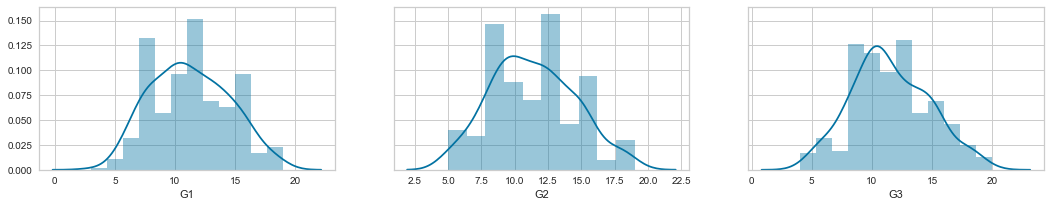

In [3]:
def explore_grades():
    helper.printHtml("Let's check grades - G1, G2, G3 distribution.")
    f, ax = plt.subplots(1, 3, figsize=(18, 3),sharey=True)
    sns.distplot(df_mathdata.G1, ax=ax[0]);
    sns.distplot(df_mathdata.G2, ax=ax[1]);
    sns.distplot(df_mathdata.G3, ax=ax[2]);
    plt.show()
    helper.printHtml("Grade range is from 0 to 20 and mostly grades average around 10.")

explore_grades()

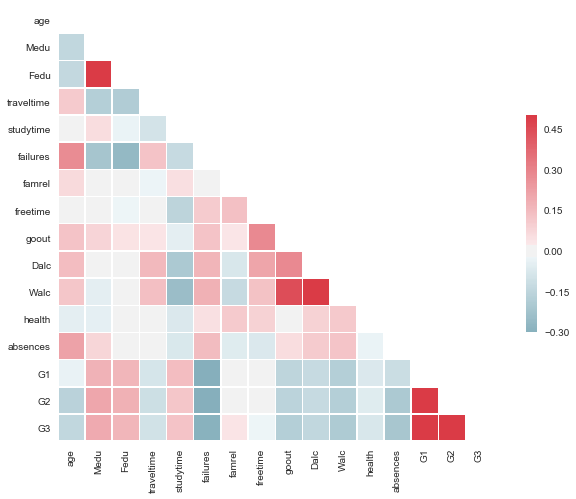

In [4]:
# visualize correlation of all the cloumns
def visualize_correlation(df):
    helper.printHtml("Let's visualize pairwise correlation of all the columns to see if any of them are strongly related.")
    corr = df.corr()
    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(12,8))
    
    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.5, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5});
    plt.show()
    helper.printHtml("Looks like Mother's and Fathers education, Day and Weekend alcohol are correlated. Based on G3 (last row) color depth - failures, G1, G2 seem to affect G3.")

    return corr;

corr = visualize_correlation(df_mathdata)

In [5]:
# sort correlation
helper.printHtml("To be more concrete, let's see all the correlation coefficients for all the columns with respect to G3 in decreasing order.")
corr['G3'].apply(lambda x: abs(x)).sort_values(ascending=False)

G3            1.000000
G2            0.965583
G1            0.891805
failures      0.293831
absences      0.213129
Medu          0.190308
Walc          0.190054
goout         0.177383
Fedu          0.158811
Dalc          0.140690
age           0.140372
studytime     0.126728
traveltime    0.099785
health        0.081691
famrel        0.037711
freetime      0.021589
Name: G3, dtype: float64

In [6]:
def check_skewness():
    helper.printHtml("Check data distribution by testing skewness, 0 - symmetric, negative - left skewed, positive - right skewed.")
    skewdata = df_mathdata.skew() 
    helper.display_data_all("Feature variability", skewdata[abs(skewdata) > 2].sort_values(ascending=False))
    helper.printHtml("There are few columns with asymetric distribution, this will affect predictive models, so data should be standardized.")
check_skewness()

absences    3.609018
failures    2.748099
Dalc        2.146276
dtype: float64

## Prediction

#### As G3 is numerical value ranging from 0 to 20, we'll build regression model to predict G3.

##### For regression task, all the column values have to be numeric, so so we'll check for categorical columns and convert them to numerics in this way:
##### - columns with two values, for e.g, yes/no - make them 0/1
##### - columns with more than two values - make a column for each value using one hot encoding process  

In [7]:
def transform_categorical_columns():
    global df_mathdata
    df_categorical_columns = pd.DataFrame(columns=['Column', 'Value Count', 'Values'])
    # categorical columns are those with value type 'object'
    categorical_columns = df_mathdata.columns[df_mathdata.dtypes == object]
    # make columns with two values as 0/1
    for i in range(len(categorical_columns)):
        colname = categorical_columns[i]
        unique_values = df_mathdata[colname].unique()
        unique_count = len(unique_values);
        first_unique_value = unique_values[0]
       # helper.printHtml("column {} has  {} values: {}".format())
        df_categorical_columns = df_categorical_columns.append({'Column':colname, 
                                                                  'Value Count':unique_count, 
                                                                  'Values':", ".join(unique_values)}, ignore_index=True)
        if (unique_count == 2):
            df_mathdata[colname] = (df_mathdata[colname] == first_unique_value)*1
        elif(unique_count > 2):
            df = pd.get_dummies(df_mathdata[colname], prefix=colname, drop_first=True)
            df_mathdata = df_mathdata.drop(columns=[colname])
            df_mathdata = pd.concat([df_mathdata, df], axis=1)
    helper.display_data("List of tansformed columns with count and unique values", df_categorical_columns, len(categorical_columns))    
            
#read_data()
#process_data()
transform_categorical_columns();

,Column,Value Count,Values
0,school,2,"GP, MS"
1,sex,2,"F, M"
2,address,2,"U, R"
3,famsize,2,"GT3, LE3"
4,Pstatus,2,"A, T"
5,Mjob,5,"at_home, health, other, services, teacher"
6,Fjob,5,"teacher, other, services, health, at_home"
7,reason,4,"course, other, home, reputation"
8,guardian,3,"mother, father, other"
9,schoolsup,2,"yes, no"


In [8]:
# define features space and target

helper.printHtml("We'll predict G3 using different feature sets with and without G1, G2.")
all_feature_columns =  [col for col in df_mathdata.columns if col not in ['G3']]
feature_columns_noG2 = [col for col in df_mathdata.columns if col not in [ 'G2', 'G3']]
feature_columns_noG1G2 = [col for col in df_mathdata.columns if col not in ['G1', 'G2', 'G3']]
features = df_mathdata.loc[:, feature_columns_noG1G2]
target = df_mathdata['G3']
helper.printHtml("For the regression models, we'll use R2 score as evaluation metric, calculate RMSE and plot graph between actual and predicted grades to see the error. ")

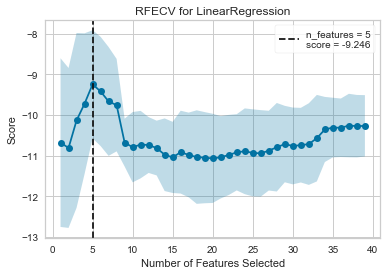

,Column
10,failures
11,schoolsup
26,Mjob_health
28,Mjob_services
33,Fjob_teacher


In [9]:
def top_five_with_lr():
    helper.printHtml("As there are 30+ features, let's get best 5 using Recursive Feature Elimination strategy using Linear Regression.")
    # Create a linear regression
    ols = LinearRegression()
    # Recursively eliminate features
    rfecv = RFECV(ols, scoring="neg_mean_squared_error")

    rfecv.fit(features, target)
    rfecv.show()
    rfecv.transform(features)
    # Number of best features
    bestfeaturecount = rfecv.n_features_
    bestfeaturesdf = pd.DataFrame({'Best': rfecv.support_, 'Ranking': rfecv.ranking_, 'Column': features.columns})
    best_five_features = bestfeaturesdf[bestfeaturesdf.Best == True][['Column']]
    helper.display_data("List of features that have highest effect on G3, we'll use these for predicting G3.", best_five_features, 5)
    return best_five_features.values.flatten()

best_five_features = top_five_with_lr()

In [10]:
helper.printHtml("Looks like failures, school support and parent's conditions have effect on grade. Let's use decision tree regression as it's one of the simplistic modelling techinque and check predictions.")

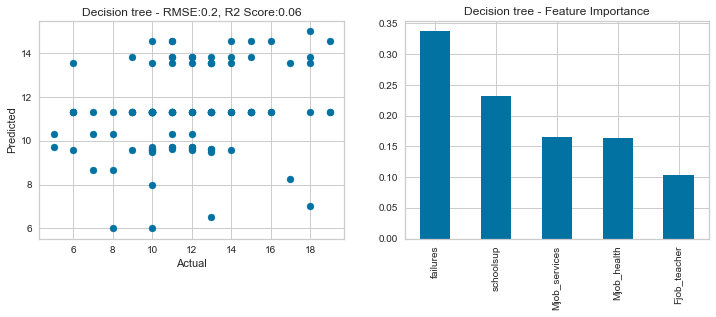

In [11]:
def predict_decisiontree(predictor_columns):
    helper.printHtml("Using Decision Tree Regression technique")
    features = df_mathdata.loc[:, predictor_columns]
    scaler = StandardScaler()
    features_standardized = scaler.fit_transform(features)
    
    features_train, features_test, target_train, target_test = train_test_split(features_standardized, target, test_size=0.3) 
    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
    dtRegressor = DecisionTreeRegressor()
    cv_results = cross_val_score(dtRegressor, features_train, target_train, cv=skf, n_jobs=-1) 
    RMSE = cv_results.mean()
    dtRegressor.fit(features_train, target_train)
    y_pred = dtRegressor.predict(features_test)
    RMSE = abs(cv_results.mean())
    Score = abs(r2_score(target_test, y_pred))
    helper.evaluate_model('Using 5 best features', 'Decision tree', RMSE, Score, 
                  target_test, y_pred, 
                  dtRegressor.feature_importances_,
                  features.columns)
    return round(Score,2)
    
accuracy = predict_decisiontree(best_five_features)

In [12]:
helper.printHtml("Prediction accuracy - {} is very low, that means it's tough to predict final grade using decision tree model with 5 best features. Let's use more features and predict using other models such as Ridge, Lasso, Random Forest regression.".format(accuracy))

In [13]:
# Function to pick best regresion model from Ridge, Lasso, Random Forest models   
def gridsearch_predict(category, predictor_columns):
    helper.printHtml("Predicting with {} columns {} using GridSearch for Ridge, Lasso, Random Forest models.".format(len(predictor_columns), category))
    alphas = [0.001, 0.1, 0.5, 1, 5, 10]
    pipe = Pipeline([("reg", LinearRegression())])
    search_space = ([
        {
            "reg": [Ridge()],
            "reg__alpha": alphas
        },
        {
            "reg": [Lasso()],
            "reg__alpha": alphas                      
        },
        {
            "reg": [RandomForestRegressor()],
            "reg__max_depth": [5,10]
        }
    ]);
    
    scaler = StandardScaler()
    features = scaler.fit_transform(df_mathdata.loc[:, predictor_columns])
    X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3) 

    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
    gridsearchmse  = GridSearchCV(pipe, search_space, scoring='neg_mean_squared_error', cv=skf)
    best_model = gridsearchmse.fit(X_train, y_train)
    y_pred = best_model.predict(X_test)

    RMSE= abs(best_model.best_score_)
    Score = r2_score(y_test, y_pred)
    regressor = best_model.best_estimator_.named_steps['reg']
    modelType = get_model_name(best_model.best_estimator_)
 
    if (modelType == 'Random Forest'):
        coeffs = regressor.feature_importances_
    else:
        coeffs = regressor.coef_

    helper.evaluate_model(category, modelType, RMSE, Score, y_test, y_pred, coeffs, predictor_columns)
    plt.show()
    helper.printHtml('Out of all the regression models - {} performed best.'.format(modelType))
    return round(Score,2)
    
# Function will return Random Forest, Ridge, Lasso model name from estimator,
def get_model_name(estimator):
    name = 'Random Forest'
    for k,v in estimator.get_params("reg").items():
        if ( k == 'reg'):
            t = type(v)
            if ( t is Lasso):
                name = 'Lasso'
            elif (t is Ridge):
                name = 'Ridge'
    return name


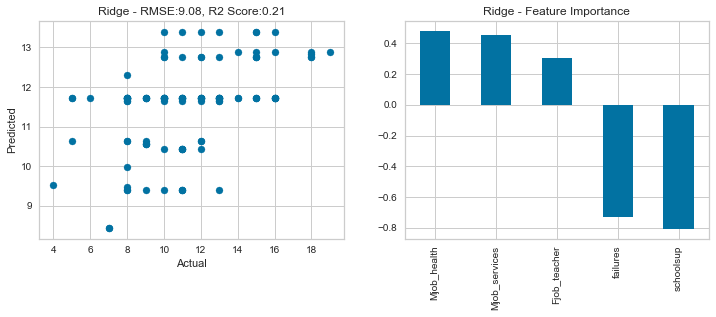

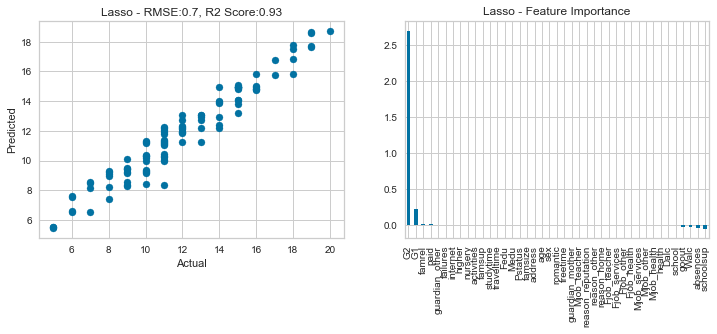

In [14]:
accuracy = gridsearch_predict("the best five features", best_five_features)
helper.printHtml("Prediction accuracy - {} isn't great, let's try all features.".format(accuracy))
accuracy = gridsearch_predict('including G1, G2', all_feature_columns)

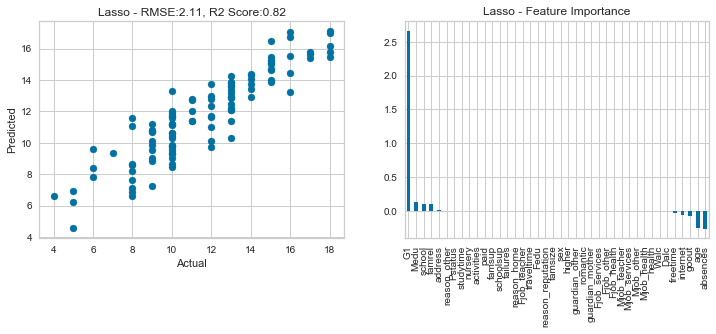

In [15]:
helper.printHtml("G2 is a good predictor with Prediction accuracy - {} , let's take out G2 and see if final grade G3 can be predicted.".format(accuracy))
accuracy = gridsearch_predict('excluding G2', feature_columns_noG2)

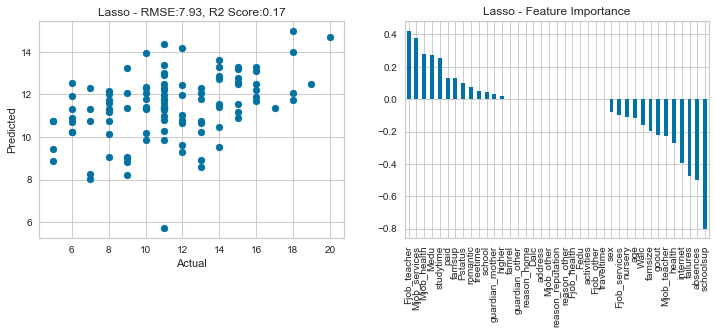

In [16]:
helper.printHtml("Taking out G2, reduced the prediction accuracy to {}, let's take G1 out too and try predicting G3.".format(accuracy))
accuracy = gridsearch_predict('excluding G1, G2', feature_columns_noG1G2)
helper.printHtml("Taking out G1 and G2, prediction accuracy dropped off to {}.".format(accuracy))

## Conclusion

In [17]:
helper.print_metrics("Summary of all the models that we've run with R2 score as predicton accuracy.")
helper.printHtml("The prediction accuracy decreases as we remove G2 and G1.")

,Model,Feature Description,RMSE,R2 Score,Selected Features
2,Lasso,"including G1, G2",0.700115,0.934497,"[G2,2.7\r, G1,0.23\r, famrel,0.02\r, paid,0.01\r, guardian_other,-0.0\r]"
3,Lasso,excluding G2,2.114862,0.816469,"[G1,2.66\r, Medu,0.13\r, school,0.11\r, famrel,0.1\r, address,0.01\r]"
1,Ridge,the best five features,9.078777,0.214393,"[Mjob_health,0.48\r, Mjob_services,0.45\r, Fjob_teacher,0.31\r, failures,-0.73\r, schoolsup,-0.81\r]"
4,Lasso,"excluding G1, G2",7.929176,0.170448,"[Fjob_teacher,0.42\r, Mjob_services,0.38\r, Mjob_health,0.28\r, Medu,0.27\r, studytime,0.25\r]"
0,Decision tree,Using 5 best features,0.202710,0.061787,"[failures,0.34\r, schoolsup,0.23\r, Mjob_services,0.16\r, Mjob_health,0.16\r, Fjob_teacher,0.1\r]"


In [18]:
helper.printHtml("Final grade can be highly predicted from Grade 2, moderately from Grade 1, however it's tough to predict without those two grades. ")
helper.printHtml("After first and second tests, school officials can work with low performing students to help with their studies and improve grade.")
helper.printHtml("As an extension to the project, the grade range can be divided into groups for e.g., 0-5 - Level 1, 6-8 as Level 2, 10-12 as Level 3, make this a classification problem and predict grade levels.")